In [687]:
%pylab inline
import re,os
n=18
max_l=6
in_root = '/mnt/store1/oliverphilcox/3PCF_QPM_v3/SE_out/qpm'
in_root2 = '/mnt/store1/oliverphilcox/3PCF_QPM_v3/SE_out_qpm/qpm'
rand_it = 12

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [688]:
def xi_reader(in_str,root1=True):
    
    if root1:
        file_name = in_root+'.'+in_str+'.out'
    else:
        file_name = in_root2+'.'+in_str+'.out'

    dat = np.zeros([n,1])

    if not os.path.exists(file_name):
        return dat
    
    with open(file_name) as f:
        start=False
        for line in f:
            if not start:
                if re.match("# Binned",line):
                    start=True
                continue
            if len(line.split())==0:
                start=False
                continue
            if re.match('# Multipole',line):
                start=False
                continue
            x=line.split()
            b=int(x[1])
            dat[b,0]=float(x[2])
            
    return dat;
    
def check_dat(arr):
    if np.isfinite(arr.sum()):
        if np.sum(np.abs(arr))>0:
            return True
    else:
        return False

In [689]:
rr=xi_reader('0.rrr',True)

all_xi = []
good_mocks = []

for mock_no in range(300):
    
    if not os.path.exists(in_root+'.%d.nnn_%d.out'%(mock_no,rand_it-1)):
        if not os.path.exists(in_root2+'.%d.nnn_%d.out'%(mock_no,rand_it-1)):
            continue;

    all_nn=[]
    for i in range(rand_it):
        tmp_in = xi_reader('%d.nnn_%d'%(mock_no,i))
        if not check_dat(tmp_in):
            # Check second directory
            tmp_in = xi_reader('%d.nnn_%d'%(mock_no,i),False)
        if check_dat(tmp_in):
            all_nn.append(tmp_in)
    
    if len(all_nn)!=rand_it:
        continue
        
    this_nn = np.mean(all_nn,axis=0)
    
    this_xi = this_nn/rr
    
    if check_dat(this_xi):
        all_xi.append(this_xi)
        good_mocks.append(mock_no)
    
all_xi = np.asarray(all_xi)
n_mocks1 = len(all_xi)
print("N_mocks = %d"%n_mocks1)

N_mocks = 163


In [690]:
xi_in = '/mnt/store1/oliverphilcox/QPM_xi/QPM_mean.xi'
xi_r = np.genfromtxt(xi_in,max_rows=1)
xi_dat = np.genfromtxt(xi_in,skip_header=2)

In [691]:
r_bins = np.arange(5,180,10)
delta_r = r_bins[1]-r_bins[0]
r_min = r_bins-delta_r/2
min_r_bin = 7


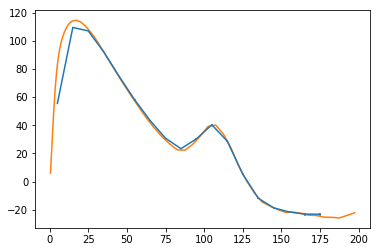

In [692]:
mean_xi = all_xi.mean(axis=0)
std_xi = all_xi.std(axis=0)
plt.errorbar(r_bins,r_bins**2*mean_xi[:,0],yerr=r_bins**2*std_xi[:,0]/np.sqrt(n_mocks1))
plt.plot(xi_r,xi_r**2*xi_dat.mean(axis=1))

In [693]:
def reader(in_str,root1=True):
    
    if root1:
        file_name = in_root+'.'+in_str+'.out'
    else:
        file_name = in_root2+'.'+in_str+'.out'
    
    dat = np.zeros([n,n,max_l+1])

    if not os.path.exists(file_name):
        return dat
    
    with open(file_name) as f:
        start=False
        for line in f:
            if not start:
                if re.match("# Multipole",line):
                    start=True
                continue
            if re.match("Multipole",line):
                continue
            if len(line.split())==0:
                start=False
                continue
            if re.match('# Saving',line):
                start=False
                continue
            x=line.split()
            b1=int(x[0])
            b2=int(x[1])
            dat[b1,b2,0]=float(x[2])/2.
            if b1!=b2:
                dat[b2,b1,0]=float(x[2])/2.
            for ell in range(1,max_l+1):
                dat[b1,b2,ell]=float(x[ell+2])*float(x[2])*(2.*ell+1.)/2.
                if b1!=b2:
                    dat[b2,b1,ell]=float(x[ell+2])*float(x[2])*(2.*ell+1.)/2.
    return dat;

In [694]:
rrr=reader('0.rrr',True)

all_zeta_uncorr = []
good_mocks2 = []

for mock_no in range(300):
    
    if mock_no not in good_mocks:
        continue

    all_n=[]
    for i in range(rand_it):
        tmp_in = reader('%d.nnn_%d'%(mock_no,i))
        if not check_dat(tmp_in):
            # Check second directory
            tmp_in = reader('%d.nnn_%d'%(mock_no,i),False)
        if check_dat(tmp_in):
            all_n.append(tmp_in)
    
    if len(all_n)!=rand_it:
        continue
    
    this_nnn = np.mean(all_n,axis=0)
    
    this_zeta = this_nnn/rrr[:,:,0].reshape(n,n,1)
    
    if check_dat(this_zeta):
        all_zeta_uncorr.append(this_zeta)
        good_mocks2.append(mock_no)
    
all_zeta_uncorr = np.asarray(all_zeta_uncorr)
n_mocks1 = len(all_zeta_uncorr)
print("N_mocks = %d"%n_mocks1)

N_mocks = 160


In [695]:
r_bins = np.arange(5,180,10)
delta_r = r_bins[1]-r_bins[0]
r_min = r_bins-delta_r/2
min_r_bin = 7

f = rrr

from sympy.physics.wigner import wigner_3j

def Mjl_calc(j,ell,flist):
    s=0
    for ellprime in np.arange(1,len(flist)):
        s+=wigner_3j(ell,ellprime,j,0,0,0)**2*flist[ellprime]
    s*=(2*j+1)
    return s    

f[:,:,:]/=f[:,:,0].reshape((n,n,1))

all_Mjl=[]
for b1 in range(len(r_bins)):
    for b2 in range(len(r_bins)):
            
        Mjl = np.zeros((max_l+1,max_l+1))
        for j in range(max_l+1):
            for k in range(max_l+1):
                Mjl[j][k]=Mjl_calc(j,k,f[b1,b2,:])
        all_Mjl.append(Mjl)

In [696]:
r_bins = np.arange(5,180,10)
delta_r = r_bins[1]-r_bins[0]
r_min = r_bins-delta_r/2
min_r_bin = 7

all_zeta = []

for mock_no in range(n_mocks1):
    
    this_zeta = np.zeros([n,n,max_l+1])
    
    print('Window-correcting mock %d of %d'%(mock_no+1,n_mocks1))
    
    ind=0
    for b1 in range(len(r_bins)):
        for b2 in range(len(r_bins)):
            
            Mjl=all_Mjl[ind]
            ind+=1
            
            geometry = np.linalg.inv(np.identity(max_l+1)+Mjl)
            
            this_zeta[b1,b2,:] = geometry.dot(all_zeta_uncorr[mock_no,b1,b2,:])

    all_zeta.append(this_zeta)

Window-correcting mock 1 of 160
Window-correcting mock 2 of 160
Window-correcting mock 3 of 160
Window-correcting mock 4 of 160
Window-correcting mock 5 of 160
Window-correcting mock 6 of 160
Window-correcting mock 7 of 160
Window-correcting mock 8 of 160
Window-correcting mock 9 of 160
Window-correcting mock 10 of 160
Window-correcting mock 11 of 160
Window-correcting mock 12 of 160
Window-correcting mock 13 of 160
Window-correcting mock 14 of 160
Window-correcting mock 15 of 160
Window-correcting mock 16 of 160
Window-correcting mock 17 of 160
Window-correcting mock 18 of 160
Window-correcting mock 19 of 160
Window-correcting mock 20 of 160
Window-correcting mock 21 of 160
Window-correcting mock 22 of 160
Window-correcting mock 23 of 160
Window-correcting mock 24 of 160
Window-correcting mock 25 of 160
Window-correcting mock 26 of 160
Window-correcting mock 27 of 160
Window-correcting mock 28 of 160
Window-correcting mock 29 of 160
Window-correcting mock 30 of 160
Window-correcting m

In [697]:
all_zeta = np.asarray(all_zeta)
n_mocks = len(all_zeta)

## Check Q ratio

#### Get Q approximation

In [699]:
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(xi_r,xi_r**2*xi_dat.mean(axis=1),s=1)

xi_fun = lambda r: spl(r)/r**2


In [700]:
from scipy.special import legendre

mu_arr = np.arange(-1.,1.,0.05)

all_Q = np.zeros([n,n,len(mu_arr)])

for b1 in range(n):
    for b2 in range(n):
        if b1==b2:
            continue
        r1 = r_bins[b1]
        r2 = r_bins[b2]

        this_zeta = all_zeta.mean(axis=0)[b1,b2]

        r3_arr = np.sqrt(r2**2+r1**2-2*r1*r2*mu_arr)

        xi_12 = xi_fun(r1)*xi_fun(r2)*np.ones_like(r3_arr)

        ells = np.arange(max_l+1)

        this_zeta_mu = np.zeros(len(mu_arr))

        for ell in ells:
            this_zeta_mu+=legendre(ell)(mu_arr)*this_zeta[ell]

        this_Q = this_zeta_mu/(xi_12+xi_fun(r1)*xi_fun(r3_arr)+xi_fun(r2)*xi_fun(r3_arr))
        
        all_Q[b1,b2]=this_Q

## Compress Q ratio

In [701]:
r_bins = np.arange(5,180,10)
delta_r = r_bins[1]-r_bins[0]
r_min = r_bins-delta_r/2
min_r_bin = 7

vol_r = 4.*np.pi/3.*((r_min+delta_r)**3-r_min**3)

Q_compress = np.zeros([n-min_r_bin,len(mu_arr)])

denom = np.zeros([n-min_r_bin])

for b1 in range(min_r_bin,n):
    for b2 in range(3,b1-3):
        Q_compress[b1-min_r_bin,:]+=all_Q[b1,b2,:]*vol_r[b2]
        denom[b1-min_r_bin]+=vol_r[b2]
    Q_compress[b1-min_r_bin,:]/=denom[b1-min_r_bin]

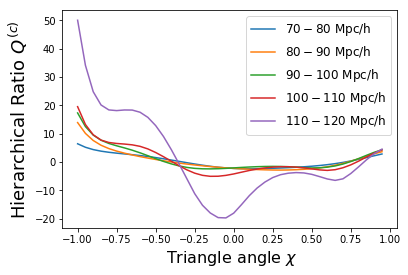

In [702]:
for i in range(len(Q_compress)-6):
    plt.plot(mu_arr,Q_compress[i],label=r'$%d-%d$ Mpc/h'%(r_min[min_r_bin+i],r_min[min_r_bin+i+1]))
plt.legend(fontsize=12)
#plt.ylim([-20,60])
plt.ylabel(r'Hierarchical Ratio $Q^{(c)}$',fontsize=18);plt.xlabel(r' Triangle angle $\chi$',fontsize=16);

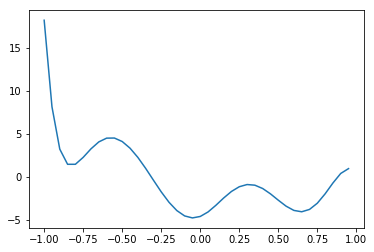

In [703]:
plt.plot(mu_arr,all_Q[6,5])

#### Compress 3PCF

In [704]:
r_bins = np.arange(5,180,10)
delta_r = r_bins[1]-r_bins[0]
r_min = r_bins-delta_r/2
min_r_bin = 7

vol_r = 4.*np.pi/3.*((r_min+delta_r)**3-r_min**3)

zeta_compress = np.zeros([n_mocks1,n-min_r_bin,max_l+1])

for i in range(n_mocks):
    denom = np.zeros([n-min_r_bin])

    for b1 in range(min_r_bin,n):
        for b2 in range(3,b1-3):
            zeta_compress[i,b1-min_r_bin,:]+=all_zeta[i,b1,b2,:]*vol_r[b2]
            denom[b1-min_r_bin]+=vol_r[b2]
        zeta_compress[i,b1-min_r_bin,:]/=denom[b1-min_r_bin]

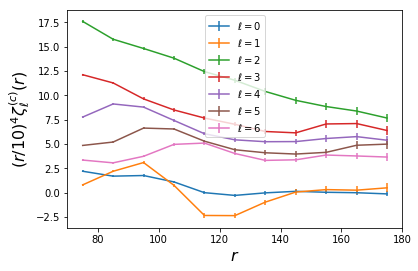

In [705]:
for ell in range(max_l+1):
    plt.errorbar(r_bins[min_r_bin:],(r_bins[min_r_bin:]/10)**4*zeta_compress.mean(axis=0)[:,ell],
                 (r_bins[min_r_bin:]/10.)**4*zeta_compress.std(axis=0)[:,ell]/np.sqrt(n_mocks),label=r'$\ell=%d$'%ell)
plt.legend();
plt.ylabel(r'$(r/10)^4\zeta^{(c)}_\ell(r)$',fontsize=16);
plt.xlabel(r'$r$',fontsize=16);

In [706]:
all_N_gal = np.load('/mnt/store1/oliverphilcox/3PCF_QPM_v3/all_N_gal.npy')
these_N_gal = all_N_gal[good_mocks2]

In [707]:
zeta_compress_flat=[]
for i in range(n_mocks):
    zeta_compress_flat.append(zeta_compress[i].T.ravel())
zeta_compress_flat=np.asarray(zeta_compress_flat)

cov_zeta = np.cov(zeta_compress_flat.T,aweights=these_N_gal/np.mean(these_N_gal))

In [708]:
def plotter(mat,vmax=np.inf,perc=99,rmax=0):
    if vmax==np.inf:
        vmax=np.percentile(mat,perc)
    plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
    plt.colorbar();
    if rmax==0:
        rmax = len(mat)
    plt.ylim([-0.5,rmax-0.5])
    plt.xlim([-0.5,rmax-0.5])

## Load theory:

In [793]:
theory = np.load('/mnt/store1/oliverphilcox/3PCF_QPM/compressed_qpm_theory.npz')
c3=theory['c3']
c4=theory['c4']
c5=theory['c5']
c6=theory['c6']-theory['c60']
c_theory = c3+c4+c5+c6

In [794]:
max_l = 6
n_mat = len(r_bins[min_r_bin:])
sample_cov = cov_zeta[:max_l*n_mat,:max_l*n_mat]
theory_cov = c_theory[:max_l*n_mat,:max_l*n_mat]

In [795]:
r_all = np.concatenate([r_bins[min_r_bin:] for _ in range(max_l)])
r_mat = np.matmul((r_all**2).reshape(-1,1),(r_all**2).reshape(1,-1))

In [796]:
from scipy.optimize import minimize

def cov_model(alpha):
    return (c3*alpha**3+c4*alpha**2+c5*alpha+c6)[:max_l*n_mat,:max_l*n_mat]


def KL_div_lin(alpha):
    c_th = cov_model(alpha)
    prec = np.linalg.inv(c_th)
    slog1 = np.linalg.slogdet(prec)
    if slog1[0]<0:
        return np.inf
    slog2 = np.linalg.slogdet(sample_cov)
    if slog2[0]<0:
        return np.inf
    return 0.5*(np.trace(np.matmul(sample_cov,prec))-slog1[1]-slog2[1]-len(sample_cov))

start_x = 1.1
x=minimize(KL_div_lin,1.1)

if x.success and x.x!=start_x:
    print("Success with alpha = %.2f"%x.x)
    c_opt = cov_model(x.x)
else:
    print("Could not fit - using alpha = 1.5")
    c_opt = cov_model(1.8)#*2

Success with alpha = 1.83


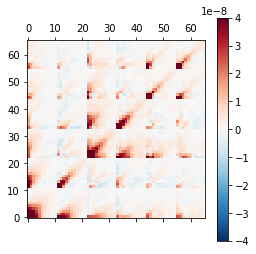

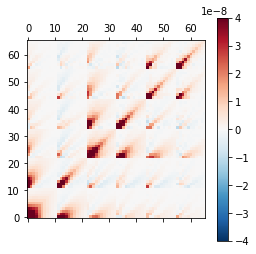

In [797]:
plotter(sample_cov,vmax=4e-8)
plotter(c_opt,vmax=4e-8)

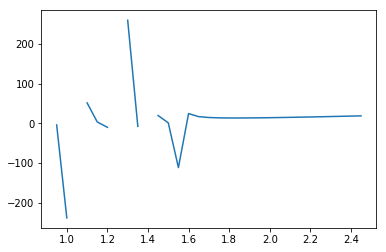

In [780]:
alphas = np.arange(0.9,2.5,0.05)
divs = [KL_div_lin(al) for al in alphas]
plt.plot(alphas,divs)

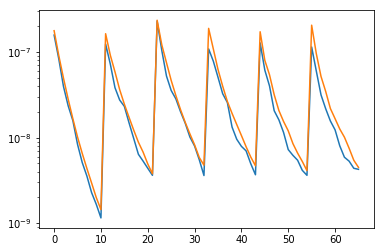

In [781]:
plt.plot(np.diag(sample_cov));
plt.plot(np.diag(c_opt))
plt.yscale('log');

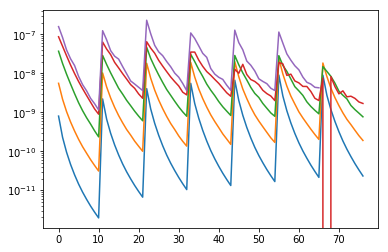

In [782]:
plt.plot(np.diag(c3))
plt.plot(np.diag(c4))
plt.plot(np.diag(c5))
plt.plot(np.diag(c6))
plt.plot(np.diag(sample_cov))
plt.yscale('log')

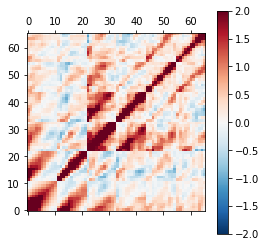

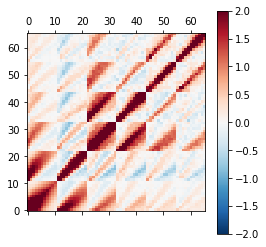

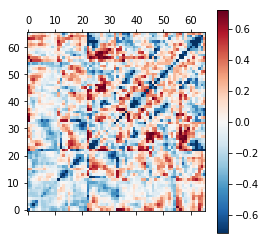

In [783]:
plotter(sample_cov*r_mat,vmax=2)
plotter(c_opt*r_mat,vmax=2)
plotter((sample_cov-c_opt)*r_mat)

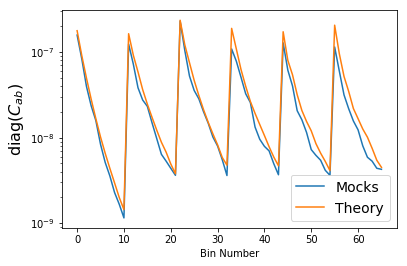

In [784]:
plt.plot(np.diag(sample_cov),label=r'Mocks')
plt.plot(np.diag(c_opt),label=r'Theory')
plt.yscale('log')
plt.legend(fontsize=14);
plt.xlabel(r'Bin Number')
plt.ylabel(r'$\mathrm{diag}(C_{ab})$',fontsize=16);

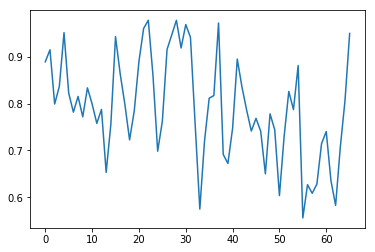

In [771]:
plt.plot(np.diag(sample_cov/c_opt))

In [772]:
def reduce(mat):
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)):
        for j in range(len(mat)):
            out_mat[i,j]=mat[i,j]/np.sqrt(mat[i,i]*mat[j,j])
    return out_mat

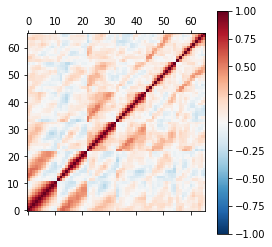

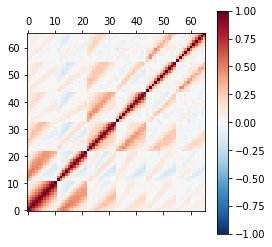

In [773]:
plotter(reduce(sample_cov))
plotter(reduce(c_opt))

In [774]:
D_mat = (len(sample_cov)+1.)/(n_mocks-1.)
prec_theory=np.linalg.inv(c_opt)
prec_obs = np.linalg.inv(sample_cov)*(1.-D_mat)

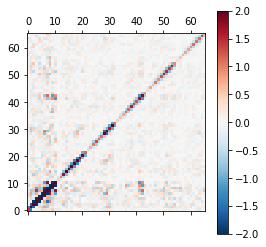

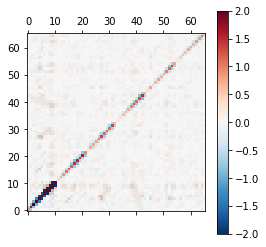

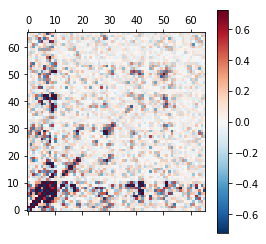

In [775]:
plotter(prec_obs/r_mat,vmax=2)
plotter(prec_theory/r_mat,vmax=2)
plotter((prec_theory-prec_obs)/r_mat)

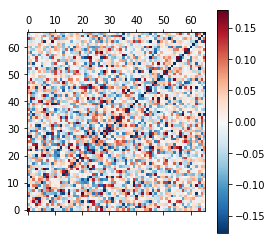

In [798]:
chol = np.linalg.cholesky(sample_cov)
disc = np.matmul(chol.T,np.matmul(prec_theory,chol))-np.eye(len(prec_theory))
plotter((disc))

In [777]:
mean_disc=np.mean(np.tril(disc))*100
rms_disc = np.std(np.tril(disc))*100
DoF = len(cov_zeta)
print("mean: %.2f rms: %.2f"%(mean_disc,rms_disc))
print("Expected RMS: %.2f"%(DoF/np.sqrt(n_mocks)))

mean: -0.44 rms: 6.53
Expected RMS: 6.09
